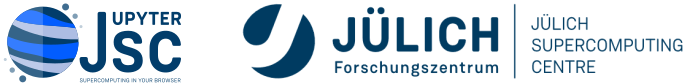
<h5 style="text-align: right">Author: <a href="mailto:j.goebbert@fz-juelich.de?subject=Jupyter-JSC%20documentation">Jens Henrik Göbbert</a></h5>  
<h5><a href="../index.ipynb">Index</a></h5>
<h1 style="text-align: center">Create your own Jupyter Kernel</h1>  

## How to load additional software modules?

[lmod](https://lmod.readthedocs.io) provides on our HPC systems a convenient way to dynamically change the users’ environment. This includes easily adding or removing directories listed in environment variables like PATH or LD_LIBRARY_PATH.  
It is a common approach on high-performance clusters to manage/install/load software packages in multiple versions/optimizations/architectures on the same machine.  
If you login to a terminal you can easily load additional modules with `module load <name>`
(for more details please read our [documentation on software modules](https://apps.fz-juelich.de/jsc/hps/juwels/software-modules.html)).

But how can you make use of these installed software modules in a Jupyter environment?

-------------------------

## Introduction

### The classical approach in the terminal
If you want to use functionality of a certain software module it can mean that you need  
* the path to its executables to be in the PATH environment variable.
* the path to its libraries to be in the LD_LIBRARY_PATH environment variable.
* the path to its python packages to be in the PYTHON_PATH environment variable.
* or any other software module specific environment variables to be set. 

In any case, running `module load <name>` in a terminal would ensure exactly that.  
It modifies the environment of the current shell, which ensures that you can use the software of the loaded modules.  

**But with Jupyter this is a bit different.**  

-------------------------------

### Why is Jupyter different when it comes to loading of software modules?

#### Jupyter's architecture
To understand how we can make additional software modules available in our Jupyter notebooks, we need to understand the basic software architecture of Jupyter first.  
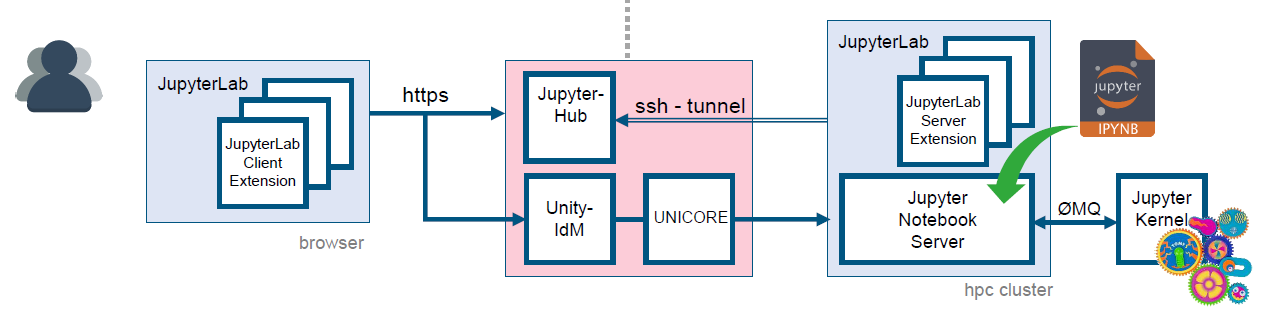

Let's skip the pink box for now, as it is only relevant if we want to discuss authentication and authorization with Jupyter-JSC.  
Hence, the pink box can be a "black box" for now.  

Just focus on
- **JupyterLab** (JavaScript/HTML in the browser) - the front-end
- **Jupyter Notebook Server** (Python on the hpc cluster) - the back-end
- **JupyterLab Kernel** (any language the kernel is made for)

JupyterLab is made of a **front-end** running in your browser using JavaScript+HTML. This is the actual user interface - one could say that its purpose is nothing else than making JupyterLab visible to you and a **back-end** running on any machine your browser can connect to.  
This back-end machine can be the same machine the browser runs on, it can be a cloud server or -in our case - the hpc cluster.  

The actual code cells of your Jupyter notebook are executed in a **separate process** called Jupyter Kernel.  
The Jupyter Kernel runs in a complete **separate shell** and communicates with the Jupyter Notebook Server through a protocol with Jupyter-specific messages.

<div class="alert alert-block alert-info">
<b>Attention:</b></br>
If you want to use a software module in your Jupyter Notebook, it must be loaded in the Jupyter Kernel's shell/environment.
</div>

There are multiple ways to load software modules into the shell/environment of the Jupyter Kernel.  
Prioritized by best approach, the options are as follows:
- create your own Jupyter Kernel
- use the lmod extension
- load the software module before starting JupyterLab
- (restart the Jupyter Kernel's process with new environment settings)

--------------------------------

#### Create your own kernel

If the standard kernels do not provide all software modules you need for your work,  
you can create your own Jupyter Kernel and load the needed software modules before you start it.

<div class="alert alert-block alert-success">
<b>Solution "own kernel":</b></br>
A Jupyter kernel is described in principle by no more than a JSON file. There you will find the command call that starts the kernel.</br>  
This command call can easily be a script, which calls a few extra `module load <..>` before.
</div>

A detailed tutorial on how to build your own Jupyter Python kernel can be found here:
- [using pip](https://gitlab.version.fz-juelich.de/jupyter4jsc/j4j_notebooks/-/blob/master/001-Jupyter/Create_JupyterKernel_general.ipynb)
- [using conda](https://gitlab.version.fz-juelich.de/jupyter4jsc/j4j_notebooks/-/blob/master/001-Jupyter/Create_JupyterKernel_conda.ipynb)

It does not take longer than **a few minutes** and you are ready to go.

-----------------------

#### lmod extension
The [lmod extension](https://github.com/cmd-ntrf/jupyter-lmod) allows users to load/unload software modules **before** launching kernels.  
You can find its UI in the left sidebar.

A Jupyter Kernel copies the environment variables of the Jupyter Notebook Server to its own separate shell when it starts up.  
The extension takes advantage of that and modifies the current environment of the Jupyter Notebook Server.

<div class="alert alert-block alert-warning">
<b>Attention "lmod":</b></br>
- you need to use the lmod extension <b>before</b> launching kernels</br>
- changes also affect the environment of the running Jupyter Notebook Server (this can have <b>side-effects</b>)</br>
- a Jupyter kernel can purge its environment and therefore <b>ignore</b> the environment variables of the Jupyter Notebook Server (module purge)</br>
</div>

-----------------------

#### Load software modules before starting JupyterLab

As you already know from the description above on the lmod extention:  
A Jupyter Kernel copies the environment variables of the Jupyter Notebook Server to its own separate shell when it starts up.  

Therefor, any software module loaded in the Jupyter Notebook Server's environment will likely be available in a standard Jupyter Kernel, too.  
If you have ensured that the extra software modules are loaded **before** JupyterLab is started.  

**But** Jupyter-JSC hides the startup of JupyterLab - it loads modules and starts JupyterLab in the background.  
Luckily we allow you to modify this startup through the file `$HOME/jupyter/start_jupyter-jsc.sh`.  

If Jupyter-JSC find the file `$HOME/jupyter/start_jupyter-jsc.sh` it sources this file instead of loading the default environment.  
Hence, you are free to load extra software modules there.
**Attention:** do not forget to load the needed Jupyter modules, too.

```bash
module purge
module use $OTHERSTAGES
module load Stages/2020
module load GCCcore/.9.3.0
module load JupyterCollection/2020.2.6

module load <...>
```

<div class="alert alert-block alert-warning">
<b>Attention "modify startup":</b></br>
- the software modules are loaded <b>every time</b></br>
- any change needs a <b>restart</b> of your JupyterLab</br>
- running multiple <b>conflicting</b> environments is impossible</br>
- changes also affect the environment of the running Jupyter Notebook Server (this can have <b>side-effects</b>)</br>
- a Jupyter kernel can purge its environment and therefore <b>ignore</b> the environment variables of the Jupyter Notebook Server (module purge)</br>
- you do not use the default JupyterLab environment and therefore will not see any <b>updates and new features</b> coming in the future
</div>

------------------------------

#### Restart the Jupyter Kernel's process from within the Jupyter notebook

If you love to live dangerously, then you can also secretly change the environment of a running Jupyter Kernel's environment.  
At least for Python there is a way to ask the current running Python interpreter to restart itself within a new/modified environment.

Please check this howto for details: [tricks with os.execve](https://gitlab.version.fz-juelich.de/jupyter4jsc/j4j_notebooks/-/blob/master/001-Jupyter/Modify_JupyterKernel_at_NotebookRuntime.ipynb)

<div class="alert alert-block alert-danger">
<b>Attention "os.execve":</b></br>
- only works with Python</br>
- is more a hack than a solution</br>
- "pollutes" the first code cells of your Jupyter notebooks the hack's commands</br>
</div>